# Objective (from the Work and Papers of Yibin Ng)
* 20191002: 
    * Given prices for the last N days, we do prediction for the next N+H days, where H is the forecast horizon
    * Using Xgboost
* 20191004 - Diff from StockPricePrediction_v6_xgboost.ipynb:
    * Instead of using mean and std from train set to do scaling/unscaling, use mean and std from the last N days to do scaling/unscaling
* 20191007 - Diff from StockPricePrediction_v6a_xgboost.ipynb:
    * Include a validation set to do hyperparameter tuning
* 20191018 - Diff from StockPricePrediction_v6b_xgboost.ipynb:
    * Instead of tuning N, we use a fixed N and observe the results
* 20191021 - Diff from StockPricePrediction_v6c_xgboost.ipynb:
    * Instead of using only features about price, introduce more features and observe the results

In [1]:
!nvidia-smi

Mon Aug  2 20:14:04 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 471.41       Driver Version: 471.41       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:06:00.0 Off |                  N/A |
| N/A   54C    P5    N/A /  N/A |    222MiB /  4096MiB |     18%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
# import chart_studio.plotly as py
import plotly.io as py
# # Set notebook mode to work in offline
# py.init_notebook_mode()
import math
import matplotlib
import numpy as np
import pandas as pd
import pickle
import plotly.graph_objects as go
import time

from collections import defaultdict
from datetime import date
from fastai import *
from fastai.tabular.all import *
# from fastai.tabular import add_datepart
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm_notebook
from xgboost import XGBRegressor

%matplotlib inline

# py.sign_in('<your-user-id>', '<your-api-key>') # sign in to plotly if you haven't done so

#### Input params ##################
folder = "C:/Users/Mister KwameNtow/Documents/GitHub/project/"
filename = "EURUSD=X (1).csv"

# Predicting on day 1008, date 2017-01-03 00:00:00
# Predicting on day 1050, date 2017-03-06 00:00:00
# Predicting on day 1092, date 2017-05-04 00:00:00
# Predicting on day 1134, date 2017-07-05 00:00:00
# Predicting on day 1176, date 2017-09-01 00:00:00
# Predicting on day 1218, date 2017-11-01 00:00:00
# Predicting on day 1260, date 2018-01-03 00:00:00
# Predicting on day 1302, date 2018-03-06 00:00:00
# Predicting on day 1344, date 2018-05-04 00:00:00
# Predicting on day 1386, date 2018-07-05 00:00:00
# Predicting on day 1428, date 2018-09-04 00:00:00
# Predicting on day 1470, date 2018-11-01 00:00:00

# pred_day1 = [1000,1200,1400,1600,2000] 
# for day in pred_day1:
#     for (n>0) & (n=n+1):
#     while(n<5):
#         pred_day = pred_day1[n]
# return pred_day
pred_day= int(input("Number of days to predict on: "))             # Predict for this day, for the next H-1 days. Note indexing of days start from 0.

H = int(input("Number of days to forecast: "))                         # Forecast horizon, in days. Note there are about 252 trading days in a year
train_size = 252*6             # Use # years of data as train set. Note there are about 252 trading days in a year
val_size = 252*3                 # Use #*1 years(24mths) of data as validation set
N = 18                         # for feature at day t, we use lags from t-1, t-2, ..., t-N as features

n_estimators = 100             # Number of boosted trees to fit. default = 100
max_depth = 4                  # Maximum tree depth for base learners. default = 3
learning_rate = 0.001            # Boosting learning rate (xgb’s “eta”). default = 0.1
min_child_weight = 1           # Minimum sum of instance weight(hessian) needed in a child. default = 1
subsample = 1                  # Subsample ratio of the training instance. default = 1
colsample_bytree = 1           # Subsample ratio of columns when constructing each tree. default = 1
colsample_bylevel = 1          # Subsample ratio of columns for each split, in each level. default = 1
gamma = 0                      # Minimum loss reduction required to make a further partition on a leaf node of the tree. default=0

model_seed = 160

fontsize = 14
ticklabelsize = 14

# Plotly colors
colors = [
    '#1f77b4',  # muted blue
    '#ff7f0e',  # safety orange
    '#2ca02c',  # cooked asparagus green
    '#d62728',  # brick red
    '#9467bd',  # muted purple
    '#8c564b',  # chestnut brown
    '#e377c2',  # raspberry yogurt pink
    '#7f7f7f',  # middle gray
    '#bcbd22',  # curry yellow-green
    '#17becf'   # blue-teal
]

####################################

train_val_size = train_size + val_size # Size of train+validation set
print("No. of days in train+validation set = " + str(train_val_size))

No. of days in train+validation set = 2268


In [ ]:
tic1 = time.time()

# Common functions

In [71]:
def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def get_mae(a, b):
    """
    Comp mean absolute error e_t = E[|a_t - b_t|]. a and b can be lists.
    Returns a vector of len = len(a) = len(b)
    """
    return np.mean(abs(np.array(a)-np.array(b)))

def get_rmse(a, b):
    """
    Comp RMSE. a and b can be lists.
    Returns a scalar.
    """
    return math.sqrt(np.mean((np.array(a)-np.array(b))**2))

In [72]:
def get_mov_avg_std(df, col, N):
    """
    Given a dataframe, get mean and std dev at timestep t using values from t-1, t-2, ..., t-N.
    Inputs
        df         : dataframe. Can be of any length.
        col        : name of the column you want to calculate mean and std dev
        N          : get mean and std dev at timestep t using values from t-1, t-2, ..., t-N
    Outputs
        df_out     : same as df but with additional column containing mean and std dev
    """
    mean_list = df[col].rolling(window = N, min_periods=1).mean() # len(mean_list) = len(df)
    std_list = df[col].rolling(window = N, min_periods=1).std()   # first value will be NaN, because normalized by N-1
    
    # Add one timestep to the predictions
    mean_list = np.concatenate((np.array([np.nan]), np.array(mean_list[:-1])))
    std_list = np.concatenate((np.array([np.nan]), np.array(std_list[:-1])))
    
    # Append mean_list to df
    df_out = df.copy()
    df_out[col + '_mean'] = mean_list
    df_out[col + '_std'] = std_list
    
    return df_out

def do_scaling(df, N):
    """
    Do scaling for the adj_close and lag cols
    """
    df.loc[:, 'adj_close_scaled'] = (df['adj_close'] - df['adj_close_mean']) / df['adj_close_std']
    for n in range(N,0,-1):
        df.loc[:, 'adj_close_scaled_lag_'+str(n)] = \
            (df['adj_close_lag_'+str(n)] - df['adj_close_mean']) / df['adj_close_std']
        
        # Remove adj_close_lag column which we don't need anymore
        df.drop(['adj_close_lag_'+str(n)], axis=1, inplace=True)

    return df

def pred_xgboost(model, X_test_ex_adj_close, N, H, prev_vals, prev_mean_val, prev_std_val):
    """
    Do recursive forecasting using xgboost
    Inputs
        model              : the xgboost model
        X_test_ex_adj_close: features of the test set, excluding adj_close_scaled values 
        N                  : for feature at day t, we use lags from t-1, t-2, ..., t-N as features
        H                  : forecast horizon
        prev_vals          : numpy array. If predict at time t, 
                             prev_vals will contain the N unscaled values at t-1, t-2, ..., t-N
        prev_mean_val      : the mean of the unscaled values at t-1, t-2, ..., t-N
        prev_std_val       : the std deviation of the unscaled values at t-1, t-2, ..., t-N
    Outputs
        Times series of predictions. Numpy array of shape (H,). This is unscaled.
    """
    forecast = prev_vals.copy()

    for n in range(H):
        forecast_scaled = (forecast[-N:] - prev_mean_val) / prev_std_val
        
        # Create the features dataframe
        X = X_test_ex_adj_close[n:n+1].copy()
        for n in range(N,0,-1):
            X.loc[:, "adj_close_scaled_lag_"+str(n)] = forecast_scaled[-n]
        
        # Do prediction
        est_scaled = model.predict(X)
        
        # Unscale the prediction
        forecast = np.concatenate([forecast, 
                                   np.array((est_scaled * prev_std_val) + prev_mean_val).reshape(1,)])
        
        # Comp. new mean and std
        prev_mean_val = np.mean(forecast[-N:])
        prev_std_val = np.std(forecast[-N:])
           
    return forecast[-H:]

def train_pred_eval_model(X_train_scaled,
                          y_train_scaled,
                          X_test_ex_adj_close,
                          y_test,
                          N,
                          H,
                          prev_vals,
                          prev_mean_val,
                          prev_std_val,
                          seed=100,
                          n_estimators=100,
                          max_depth=3,
                          learning_rate=0.01,
                          min_child_weight=1,
                          subsample=1,
                          colsample_bytree=1,
                          colsample_bylevel=1,
                          gamma=0):
    '''
    Train model, do prediction, scale back to original range and do evaluation
    Use XGBoost here.
    Inputs
        X_train_scaled     : features for training. Scaled to have mean 0 and variance 1
        y_train_scaled     : target for training. Scaled to have mean 0 and variance 1
        X_test_ex_adj_close: features of the test set, excluding adj_close_scaled values 
        y_test             : target for test. Actual values, not scaled.
        N                  : for feature at day t, we use lags from t-1, t-2, ..., t-N as features
        H                  : forecast horizon
        prev_vals          : numpy array. If predict at time t, 
                             prev_vals will contain the N unscaled values at t-1, t-2, ..., t-N
        prev_mean_val      : the mean of the unscaled values at t-1, t-2, ..., t-N
        prev_std_val       : the std deviation of the unscaled values at t-1, t-2, ..., t-N
        seed               : model seed
        n_estimators       : number of boosted trees to fit
        max_depth          : maximum tree depth for base learners
        learning_rate      : boosting learning rate (xgb’s “eta”)
        min_child_weight   : minimum sum of instance weight(hessian) needed in a child
        subsample          : subsample ratio of the training instance
        colsample_bytree   : subsample ratio of columns when constructing each tree
        colsample_bylevel  : subsample ratio of columns for each split, in each level
        gamma              : 
    Outputs
        rmse               : root mean square error of y_test and est
        mape               : mean absolute percentage error of y_test and est
        mae                : mean absolute error of y_test and est
        est                : predicted values. Same length as y_test
    '''

    model = XGBRegressor(objective ='reg:squarederror',
                         seed=model_seed,
                         n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         subsample=subsample,
                         colsample_bytree=colsample_bytree,
                         colsample_bylevel=colsample_bylevel,
                         gamma=gamma)
        
    # Train the model
    model.fit(X_train_scaled, y_train_scaled)
    
    # Get predicted labels and scale back to original range
    est = pred_xgboost(model, X_test_ex_adj_close, N, H, prev_vals, prev_mean_val, prev_std_val)

    # Calculate RMSE, MAPE, MAE
    rmse = get_rmse(y_test, est)
    mape = get_mape(y_test, est)
    mae = get_mae(y_test, est)
    
    return rmse, mape, mae, est, model.feature_importances_

def add_lags(df, N, lag_cols):
    """
    Add lags up to N number of days to use as features
    The lag columns are labelled as 'adj_close_lag_1', 'adj_close_lag_2', ... etc.
    """
    # Use lags up to N number of days to use as features
    df_w_lags = df.copy()
    df_w_lags.loc[:, 'order_day'] = [x for x in list(range(len(df)))] # Add a column 'order_day' to indicate the order of the rows by date
    merging_keys = ['order_day'] # merging_keys
    shift_range = [x+1 for x in range(N)]
    for shift in shift_range:
        train_shift = df_w_lags[merging_keys + lag_cols].copy()
    
        # E.g. order_day of 0 becomes 1, for shift = 1.
        # So when this is merged with order_day of 1 in df_w_lags, this will represent lag of 1.
        train_shift['order_day'] = train_shift['order_day'] + shift
    
        foo = lambda x: '{}_lag_{}'.format(x, shift) if x in lag_cols else x
        train_shift = train_shift.rename(columns=foo)

        df_w_lags = pd.merge(df_w_lags, train_shift, on=merging_keys, how='left') #.fillna(0)
    del train_shift
    
    return df_w_lags

def get_error_metrics(df,
                      train_size,
                      N,
                      H,
                      seed=100,
                      n_estimators=100,
                      max_depth=3,
                      learning_rate=0.01,
                      min_child_weight=1,
                      subsample=1,
                      colsample_bytree=1,
                      colsample_bylevel=1,
                      gamma=0):
    """
    Given a series consisting of both train+validation, do predictions of forecast horizon H on the validation set, 
    at H/2 intervals.
    Inputs
        df                 : train + val dataframe. len(df) = train_size + val_size
        train_size         : size of train set
        N                  : for feature at day t, we use lags from t-1, t-2, ..., t-N as features
        H                  : forecast horizon
        seed               : model seed
        n_estimators       : number of boosted trees to fit
        max_depth          : maximum tree depth for base learners
        learning_rate      : boosting learning rate (xgb’s “eta”)
        min_child_weight   : minimum sum of instance weight(hessian) needed in a child
        subsample          : subsample ratio of the training instance
        colsample_bytree   : subsample ratio of columns when constructing each tree
        colsample_bylevel  : subsample ratio of columns for each split, in each level
        gamma              : 

    Outputs
        mean of rmse, mean of mape, mean of mae, dictionary of predictions
    """
    rmse_list = [] # root mean square error
    mape_list = [] # mean absolute percentage error
    mae_list = []  # mean absolute error
    preds_dict = {}
    
    # Add lags up to N number of days to use as features
    df = add_lags(df, N, ['adj_close'])
    
    # Get mean and std dev at timestamp t using values from t-1, ..., t-N
    df = get_mov_avg_std(df, 'adj_close', N)
    
    # Do scaling
    df = do_scaling(df, N)
    
    # Get list of features
    features_ex_adj_close = [
        'year',
        'month',
        'week',
        'day',
        'dayofweek',
        'dayofyear',
        'is_month_end',
        'is_month_start',
        'is_quarter_end',
        'is_quarter_start',
        'is_year_end'
    ]
    features = features_ex_adj_close # features contain all features, including adj_close_lags
    for n in range(N,0,-1):
        features.append("adj_close_scaled_lag_"+str(n))
    
    for i in range(train_size, len(df)-H+1, int(H/2)):
        # Split into train and test
        train = df[i-train_size:i].copy()
        test = df[i:i+H].copy()
    
        # Drop the NaNs in train
        train.dropna(axis=0, how='any', inplace=True)
    
        # Split into X and y
        X_train_scaled = train[features]
        y_train_scaled = train['adj_close_scaled']
        X_test_ex_adj_close = test[features_ex_adj_close]
        y_test = test['adj_close']
        prev_vals = train[-N:]['adj_close'].to_numpy()
        prev_mean_val = test.iloc[0]['adj_close_mean']
        prev_std_val = test.iloc[0]['adj_close_std']
            
        rmse, mape, mae, est, _ = train_pred_eval_model(X_train_scaled,
                                                        y_train_scaled,
                                                        X_test_ex_adj_close,
                                                        y_test,
                                                        N,
                                                        H,
                                                        prev_vals,
                                                        prev_mean_val,
                                                        prev_std_val,
                                                        seed=seed,
                                                        n_estimators=n_estimators,
                                                        max_depth=max_depth,
                                                        learning_rate=learning_rate,
                                                        min_child_weight=min_child_weight,
                                                        subsample=subsample,
                                                        colsample_bytree=colsample_bytree,
                                                        colsample_bylevel=colsample_bylevel,
                                                        gamma=gamma)
#         print("N = " + str(N) + ", i = " + str(i) + ", rmse = " + str(rmse) + ", mape = " + str(mape) + ", mae = " + str(mae))
        
        rmse_list.append(rmse)
        mape_list.append(mape)
        mae_list.append(mae)
        preds_dict[i] = est
    
    return np.mean(rmse_list), np.mean(mape_list), np.mean(mae_list), preds_dict 

def get_error_metrics_one_pred(df,
                               train_size,
                               N,
                               H,
                               seed=100,
                               n_estimators=100,
                               max_depth=3,
                               learning_rate=0.1,
                               min_child_weight=1,
                               subsample=1,
                               colsample_bytree=1,
                               colsample_bylevel=1,
                               gamma=0):
    """
    Given a series consisting of both train+test, do one prediction of forecast horizon H on the test set.
    Inputs
        df                 : train + test dataframe. len(df) = train_size + test_size
        train_size         : size of train set
        N                  : for feature at day t, we use lags from t-1, t-2, ..., t-N as features
        H                  : forecast horizon
        seed               : model seed
        n_estimators       : number of boosted trees to fit
        max_depth          : maximum tree depth for base learners
        learning_rate      : boosting learning rate (xgb’s “eta”)
        min_child_weight   : minimum sum of instance weight(hessian) needed in a child
        subsample          : subsample ratio of the training instance
        colsample_bytree   : subsample ratio of columns when constructing each tree
        colsample_bylevel  : subsample ratio of columns for each split, in each level
        gamma              : 

    Outputs
        rmse, mape, mae, predictions
    """    
    # Add lags up to N number of days to use as features
    df = add_lags(df, N, ['adj_close'])
    
    # Get mean and std dev at timestamp t using values from t-1, ..., t-N
    df = get_mov_avg_std(df, 'adj_close', N)
    
    # Do scaling
    df = do_scaling(df, N)
    
    # Get list of features
    features_ex_adj_close = [
        'year',
        'month',
        'week',
        'day',
        'dayofweek',
        'dayofyear',
        'is_month_end',
        'is_month_start',
        'is_quarter_end',
        'is_quarter_start',
        'is_year_end'
    ]
    features = features_ex_adj_close # features contain all features, including adj_close_lags
    for n in range(N,0,-1):
        features.append("adj_close_scaled_lag_"+str(n))
    
    # Split into train and test
    train = df[:train_size].copy()
    test = df[train_size:train_size+H].copy()
    
    # Drop the NaNs in train
    train.dropna(axis=0, how='any', inplace=True)
    
    # Split into X and y
    X_train_scaled = train[features]
    y_train_scaled = train['adj_close_scaled']
    X_test_ex_adj_close = test[features_ex_adj_close]
    y_test = test['adj_close']
    prev_vals = train[-N:]['adj_close'].to_numpy()
    prev_mean_val = test.iloc[0]['adj_close_mean']
    prev_std_val = test.iloc[0]['adj_close_std']
            
    rmse, mape, mae, est, feature_importances = train_pred_eval_model(X_train_scaled,
                                                                      y_train_scaled,
                                                                      X_test_ex_adj_close,
                                                                      y_test,
                                                                      N,
                                                                      H,
                                                                      prev_vals,
                                                                      prev_mean_val,
                                                                      prev_std_val,
                                                                      seed=seed,
                                                                      n_estimators=n_estimators,
                                                                      max_depth=max_depth,
                                                                      learning_rate=learning_rate,
                                                                      min_child_weight=min_child_weight,
                                                                      subsample=subsample,
                                                                      colsample_bytree=colsample_bytree,
                                                                      colsample_bylevel=colsample_bylevel,
                                                                      gamma=gamma)
    
    return rmse, mape, mae, est, feature_importances, features

# Load data

In [73]:
df = pd.read_csv(folder+filename, sep = ",")

# Convert Date column to datetime
df.loc[:, 'Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
# df.loc[:, 'Date'] = df['Date'].apply(lambda x: datetime.fromtimestamp( (x - 25569) *86400.0))

# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

# Sort by datetime
df.sort_values(by='date', inplace=True, ascending=True)

df.head(10)

,date,open,high,low,close,adj_close,volume
0,2007-08-24,1.355803,1.368701,1.355601,1.366699,1.366699,0.0
1,2007-08-27,1.367596,1.368701,1.363698,1.363791,1.363791,0.0
2,2007-08-28,1.363791,1.367895,1.359897,1.359897,1.359897,0.0
3,2007-08-29,1.360100,1.368195,1.356502,1.367409,1.367409,0.0
4,2007-08-30,1.366904,1.367708,1.359601,1.364201,1.364201,0.0
5,2007-08-31,1.364592,1.372006,1.362305,1.364201,1.364201,0.0
6,2007-09-03,1.363401,1.365505,1.360803,1.361396,1.361396,0.0
7,2007-09-04,1.361396,1.362806,1.355601,1.362008,1.362008,0.0
8,2007-09-05,1.361804,1.367204,1.357202,1.365393,1.365393,0.0
9,2007-09-06,1.365393,1.371009,1.363791,1.369600,1.369600,0.0


In [74]:
df=df.fillna(value=df.mean())
df.head(16)

<ipython-input-74-9d7014c5c73d>:1: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.



,date,open,high,low,close,adj_close,volume
0,2007-08-24,1.355803,1.368701,1.355601,1.366699,1.366699,0.0
1,2007-08-27,1.367596,1.368701,1.363698,1.363791,1.363791,0.0
2,2007-08-28,1.363791,1.367895,1.359897,1.359897,1.359897,0.0
3,2007-08-29,1.360100,1.368195,1.356502,1.367409,1.367409,0.0
4,2007-08-30,1.366904,1.367708,1.359601,1.364201,1.364201,0.0
5,2007-08-31,1.364592,1.372006,1.362305,1.364201,1.364201,0.0
6,2007-09-03,1.363401,1.365505,1.360803,1.361396,1.361396,0.0
7,2007-09-04,1.361396,1.362806,1.355601,1.362008,1.362008,0.0
8,2007-09-05,1.361804,1.367204,1.357202,1.365393,1.365393,0.0
9,2007-09-06,1.365393,1.371009,1.363791,1.369600,1.369600,0.0


In [75]:
df.head(15)

,date,open,high,low,close,adj_close,volume
0,2007-08-24,1.355803,1.368701,1.355601,1.366699,1.366699,0.0
1,2007-08-27,1.367596,1.368701,1.363698,1.363791,1.363791,0.0
2,2007-08-28,1.363791,1.367895,1.359897,1.359897,1.359897,0.0
3,2007-08-29,1.360100,1.368195,1.356502,1.367409,1.367409,0.0
4,2007-08-30,1.366904,1.367708,1.359601,1.364201,1.364201,0.0
5,2007-08-31,1.364592,1.372006,1.362305,1.364201,1.364201,0.0
6,2007-09-03,1.363401,1.365505,1.360803,1.361396,1.361396,0.0
7,2007-09-04,1.361396,1.362806,1.355601,1.362008,1.362008,0.0
8,2007-09-05,1.361804,1.367204,1.357202,1.365393,1.365393,0.0
9,2007-09-06,1.365393,1.371009,1.363791,1.369600,1.369600,0.0


In [76]:
# Remove columns which you can't use as features
df.drop(['open', 'high', 'low', 'close', 'volume'], axis=1, inplace=True)

In [77]:
# Plot with plotly
data = [go.Scatter(
            x = df['date'],
            y = df['adj_close'],
            mode = 'lines')]

layout = dict(xaxis = dict(title = 'date'),
              yaxis = dict(title = 'Trade Rate'))

fig = dict(data=data, layout=layout)
py.show(fig, filename=filename)

# Feature Engineering

In [78]:
#create features
add_datepart(df, 'date', drop=False)
df.drop('Elapsed', axis=1, inplace=True)  # don't need this
df.head(50)

,date,adj_close,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
0,2007-08-24,1.366699,2007,8,34,24,4,236,False,False,False,False,False,False
1,2007-08-27,1.363791,2007,8,35,27,0,239,False,False,False,False,False,False
2,2007-08-28,1.359897,2007,8,35,28,1,240,False,False,False,False,False,False
3,2007-08-29,1.367409,2007,8,35,29,2,241,False,False,False,False,False,False
4,2007-08-30,1.364201,2007,8,35,30,3,242,False,False,False,False,False,False
5,2007-08-31,1.364201,2007,8,35,31,4,243,True,False,False,False,False,False
6,2007-09-03,1.361396,2007,9,36,3,0,246,False,False,False,False,False,False
7,2007-09-04,1.362008,2007,9,36,4,1,247,False,False,False,False,False,False
8,2007-09-05,1.365393,2007,9,36,5,2,248,False,False,False,False,False,False
9,2007-09-06,1.369600,2007,9,36,6,3,249,False,False,False,False,False,False


In [79]:
# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

In [80]:
# Convert year to categorical feature, based on alphabetical order and status(if availiable) as well
df.loc[:, 'year'] = LabelEncoder().fit_transform(df['year'])
# df.loc[:, 'status']=LabelEncoder().fit_transform(df['status'])
df[15:25]

,date,adj_close,year,month,week,day,dayofweek,dayofyear,is_month_end,is_month_start,is_quarter_end,is_quarter_start,is_year_end,is_year_start
15,2007-09-14,1.387809,0,9,37,14,4,257,False,False,False,False,False,False
16,2007-09-17,1.386501,0,9,38,17,0,260,False,False,False,False,False,False
17,2007-09-18,1.397995,0,9,38,18,1,261,False,False,False,False,False,False
18,2007-09-19,1.396902,0,9,38,19,2,262,False,False,False,False,False,False
19,2007-09-20,1.407895,0,9,38,20,3,263,False,False,False,False,False,False
20,2007-09-21,1.409205,0,9,38,21,4,264,False,False,False,False,False,False
21,2007-09-24,1.407400,0,9,39,24,0,267,False,False,False,False,False,False
22,2007-09-25,1.415208,0,9,39,25,1,268,False,False,False,False,False,False
23,2007-09-26,1.413308,0,9,39,26,2,269,False,False,False,False,False,False
24,2007-09-27,1.415208,0,9,39,27,3,270,False,False,False,False,False,False


# EDA

In [81]:
# Count number of nulls for each column
df.isnull().sum(axis=0)

date                0
adj_close           0
year                0
month               0
week                0
day                 0
dayofweek           0
dayofyear           0
is_month_end        0
is_month_start      0
is_quarter_end      0
is_quarter_start    0
is_year_end         0
is_year_start       0
dtype: int64

In [82]:
# Compute the average price for each month
avg_price_mth = df.groupby("month").agg({'adj_close': 'mean'}).reset_index()

# Plot 
data = [go.Scatter(
            x = avg_price_mth['month'],
            y = avg_price_mth['adj_close'],
            mode = 'markers',
            marker=dict(
                color='LightSkyBlue',
                size=15,
                line=dict(
                color='MediumPurple',
                width=2
                ))
        )]

layout = dict(xaxis = dict(title = 'month'),
              yaxis = dict(title = 'average adjusted closing price (EURUSD)'))

fig = dict(data=data, layout=layout)
py.show(fig, filename='ForexPricePrediction_v6d_avg_price_mth')

In [83]:
# Compute the average price for each day of month
avg_price_day = df.groupby("day").agg({'adj_close': 'mean'}).reset_index()

# Plot 
data = [go.Scatter(
            x = avg_price_day['day'],
            y = avg_price_day['adj_close'],
            mode = 'markers',
            marker=dict(
                color='LightSkyBlue',
                size=15,
                line=dict(
                color='MediumPurple',
                width=2
                ))
        )]

layout = dict(xaxis = dict(title = 'day of month'),
              yaxis = dict(title = 'average adjusted closing price (EURUSD)'))

fig = dict(data=data, layout=layout)
py.show(fig, filename='ForexPricePrediction_v6d_avg_price_dayofmonth')

In [84]:
# Compute the average price for each day of week
avg_price_dayofweek = df.groupby("dayofweek").agg({'adj_close': 'mean'}).reset_index()

# Plot 
data = [go.Scatter(
            x = avg_price_dayofweek['dayofweek'],
            y = avg_price_dayofweek['adj_close'],
            mode = 'markers',
            marker=dict(
                color='LightSkyBlue',
                size=15,
                line=dict(
                color='MediumPurple',
                width=2
                ))
        )]

layout = dict(xaxis = dict(title = 'day of week'),
              yaxis = dict(title = 'average adjusted closing price (USD)'))

fig = dict(data=data, layout=layout)
py.show(fig, filename='ForexPricePrediction_v6d_avg_price_dayofweek')

In [85]:
# Create lags 
df_lags = add_lags(df, N, ['adj_close'])
df_lags

,date,adj_close,year,month,week,day,dayofweek,dayofyear,is_month_end,is_month_start,...,adj_close_lag_9,adj_close_lag_10,adj_close_lag_11,adj_close_lag_12,adj_close_lag_13,adj_close_lag_14,adj_close_lag_15,adj_close_lag_16,adj_close_lag_17,adj_close_lag_18
0,2007-08-24,1.366699,0,8,34,24,4,236,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2007-08-27,1.363791,0,8,35,27,0,239,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2007-08-28,1.359897,0,8,35,28,1,240,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2007-08-29,1.367409,0,8,35,29,2,241,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2007-08-30,1.364201,0,8,35,30,3,242,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3561,2021-04-19,1.196945,14,4,16,19,0,109,False,False,...,1.181893,1.176817,1.177995,1.172883,1.172360,1.177101,1.178800,1.177662,1.181307,1.184021
3562,2021-04-20,1.204529,14,4,16,20,1,110,False,False,...,1.187423,1.181893,1.176817,1.177995,1.172883,1.172360,1.177101,1.178800,1.177662,1.181307
3563,2021-04-21,1.203239,14,4,16,21,2,111,False,False,...,1.187366,1.187423,1.181893,1.176817,1.177995,1.172883,1.172360,1.177101,1.178800,1.177662
3564,2021-04-22,1.203775,14,4,16,22,3,112,False,False,...,1.191568,1.187366,1.187423,1.181893,1.176817,1.177995,1.172883,1.172360,1.177101,1.178800


In [86]:
# Compute correlation
features = [
        'adj_close',
        'year',
        'month',
        'week',
        'day',
        'dayofweek',
        'dayofyear',
        'is_month_end',
        'is_month_start',
        'is_quarter_end',
        'is_quarter_start',
        'is_year_end',
        'is_year_start'
]
for n in range(N,0,-1):
    features.append("adj_close_lag_"+str(n))
        
corr_matrix = df_lags[features].corr()
corr_matrix["adj_close"].sort_values(ascending=False)

adj_close           1.000000
adj_close_lag_1     0.986794
adj_close_lag_2     0.984153
adj_close_lag_3     0.981072
adj_close_lag_4     0.978196
adj_close_lag_5     0.975589
adj_close_lag_6     0.973449
adj_close_lag_7     0.970456
adj_close_lag_8     0.967340
adj_close_lag_9     0.964199
adj_close_lag_10    0.960783
adj_close_lag_11    0.957553
adj_close_lag_12    0.955678
adj_close_lag_13    0.952658
adj_close_lag_14    0.949605
adj_close_lag_15    0.946555
adj_close_lag_16    0.944294
adj_close_lag_17    0.940691
adj_close_lag_18    0.938859
dayofyear           0.029509
month               0.029209
week                0.026864
is_quarter_end      0.016436
is_year_end         0.011071
is_month_end        0.009993
day                 0.007457
is_year_start       0.005409
is_quarter_start    0.005341
dayofweek           0.003361
is_month_start     -0.007809
year               -0.795528
Name: adj_close, dtype: float64

In [87]:
# Plot correlation for lag features only
features = ['adj_close']
for n in range(1,N+1,1):
    features.append("adj_close_lag_"+str(n))
        
corr_matrix = df_lags[features].corr()

z_list = []
for feat in features:
    z_list.append(corr_matrix.loc[:, feat][features])

fig = go.Figure(data=go.Heatmap(
                   z=z_list,
                   x=features,
                   y=features))
py.show(fig, filename='ForexPricePrediction_v6d_corr_matrix_lags')

In [88]:
# Plot correlation for date features only
features = [
        'adj_close',
        'year',
        'month',
        'week',
        'day',
        'dayofweek',
        'dayofyear',
        'is_month_end',
        'is_month_start',
        'is_quarter_end',
        'is_quarter_start',
        'is_year_end',
        'is_year_start'
]
        
corr_matrix = df_lags[features].corr()

z_list = []
for feat in features:
    z_list.append(corr_matrix.loc[:, feat][features])

fig = go.Figure(data=go.Heatmap(
                   z=z_list,
                   x=features,
                   y=features))
py.show(fig, filename='ForexPricePrediction_v6d_corr_matrix_dates')

# Split into train, validation, test

In [89]:
print("Predicting on day %d, date %s, with forecast horizon H = %d" % (pred_day, df.iloc[pred_day]['date'], H))

Predicting on day 2600, date 2017-08-11 00:00:00, with forecast horizon H = 30


In [90]:
train = df[(pred_day-train_val_size):(pred_day-val_size)].copy()
val = df[pred_day-val_size:pred_day].copy()
train_val = df[pred_day-train_val_size:pred_day].copy()
test = df[pred_day:pred_day+H].copy()
print("train.shape = " + str(train.shape))
print("val.shape = " + str(val.shape))
print("train_val.shape = " + str(train_val.shape))
print("test.shape = " + str(test.shape))

train.shape = (1512, 14)
val.shape = (756, 14)
train_val.shape = (2268, 14)
test.shape = (30, 14)


In [91]:
df.head(5)

,date,adj_close,year,month,week,day,dayofweek,dayofyear,is_month_end,is_month_start,is_quarter_end,is_quarter_start,is_year_end,is_year_start
0,2007-08-24,1.366699,0,8,34,24,4,236,False,False,False,False,False,False
1,2007-08-27,1.363791,0,8,35,27,0,239,False,False,False,False,False,False
2,2007-08-28,1.359897,0,8,35,28,1,240,False,False,False,False,False,False
3,2007-08-29,1.367409,0,8,35,29,2,241,False,False,False,False,False,False
4,2007-08-30,1.364201,0,8,35,30,3,242,False,False,False,False,False,False


# Predict for a specific H (forecast horizon) and a specific date

In [92]:
# Get error metrics on validation set before hyperparameter tuning
rmse_bef_tuning, mape_bef_tuning, mae_bef_tuning, preds_dict = \
                                                      get_error_metrics(train_val,
                                                                        train_size,
                                                                        N,
                                                                        H,
                                                                        seed=model_seed,
                                                                        n_estimators=n_estimators,
                                                                        max_depth=max_depth,
                                                                        learning_rate=learning_rate,
                                                                        min_child_weight=min_child_weight,
                                                                        subsample=subsample,
                                                                        colsample_bytree=colsample_bytree,
                                                                        colsample_bylevel=colsample_bylevel,
                                                                        gamma=gamma)
print("RMSE = %0.3f" % rmse_bef_tuning)
print("MAPE = %0.3f%%" % mape_bef_tuning)
print("MAE = %0.3f%%" % mae_bef_tuning)

RMSE = 0.026
MAPE = 2.028%
MAE = 0.023%


In [93]:
preds_dict

2685 , 1.30734503, 1.3074013 ]),
 1527: array([1.28154051, 1.28185153, 1.28135145, 1.28017807, 1.27964628,
        1.2786727 , 1.27823114, 1.27765274, 1.27698863, 1.27680504,
        1.27688038, 1.27702403, 1.27746093, 1.2783767 , 1.27875555,
        1.27929974, 1.27944326, 1.27967477, 1.27963257, 1.27955282,
        1.2793256 , 1.2791245 , 1.27903259, 1.27898288, 1.2789886 ,
        1.27898896, 1.27905571, 1.2791363 , 1.27921093, 1.27927172]),
 1542: array([1.27373874, 1.27374291, 1.27415943, 1.27452338, 1.27453804,
        1.27484012, 1.27526891, 1.275442  , 1.2758491 , 1.27551627,
        1.27506518, 1.27507293, 1.27444243, 1.27463758, 1.27487719,
        1.27501392, 1.27506018, 1.2750361 , 1.27508795, 1.27513218,
        1.27516806, 1.27519989, 1.27522755, 1.27525401, 1.2752744 ,
        1.27527487, 1.27527857, 1.27521777, 1.27519011, 1.27518559]),
 1557: array([1.25785804, 1.25691032, 1.2562778 , 1.25433791, 1.2534889 ,
        1.25274909, 1.2525512 , 1.25272965, 1.25254142, 1.252

In [94]:
# Plot validation predictions
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=train['date'], 
                         y=train['adj_close'],
                         mode='lines',
                         name='train',
                         line=dict(color='blue')))
fig.add_trace(go.Scatter(x=val['date'], 
                         y=val['adj_close'],
                         mode='lines',
                         name='validation',
                         line=dict(color='orange')))
fig.add_trace(go.Scatter(x=test['date'], 
                         y=test['adj_close'],
                         mode='lines',
                         name='actual',
                         line=dict(color='green')))

# Plot the predictions
n = 0
for key in preds_dict:
    fig.add_trace(go.Scatter(x=train_val[key:key+H]['date'], 
                             y=preds_dict[key],
                             mode='lines',
                             name='predictions',
                             line=dict(color=colors[n%len(colors)])))
    n = n + 1

fig.update_layout(yaxis=dict(title='USD'),
                  xaxis=dict(title='date'))
fig.update_xaxes(range=['2007-08-24', '2018-11-12'])
fig.update_yaxes(range=[127, 157])
py.show(fig, filename='ForexPricePrediction_v6d_xgboost_val')

In [95]:
# Do prediction on test set
test_rmse_bef_tuning, test_mape_bef_tuning, test_mae_bef_tuning, est, feature_importances, features = \
                                            get_error_metrics_one_pred(df[pred_day-train_val_size:pred_day+H],
                                                                       train_size+val_size,
                                                                       N,
                                                                       H,
                                                                       seed=model_seed,
                                                                       n_estimators=n_estimators,
                                                                       max_depth=max_depth,
                                                                       learning_rate=learning_rate,
                                                                       min_child_weight=min_child_weight,
                                                                       subsample=subsample,
                                                                       colsample_bytree=colsample_bytree,
                                                                       colsample_bylevel=colsample_bylevel,
                                                                       gamma=gamma)

print("RMSE = %0.3f" % test_rmse_bef_tuning)
print("MAPE = %0.3f%%" % test_mape_bef_tuning)
print("MAE = %0.3f" % test_mae_bef_tuning)

RMSE = 0.011
MAPE = 0.795%
MAE = 0.009


In [96]:
# Plot test predictions
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=train['date'], 
                         y=train['adj_close'],
                         mode='lines',
                         name='train',
                         line=dict(color='blue')))
fig.add_trace(go.Scatter(x=val['date'], 
                         y=val['adj_close'],
                         mode='lines',
                         name='validation',
                         line=dict(color='orange')))
fig.add_trace(go.Scatter(x=test['date'], 
                         y=test['adj_close'],
                         mode='lines',
                         name='real values',
                         line=dict(color='green')))
fig.add_trace(go.Scatter(x=test[:H]['date'], 
                         y=est,
                         mode='lines',
                         name='predictions',
                         line=dict(color='red')))
fig.update_layout(yaxis=dict(title='USD'),
                  xaxis=dict(title='date'))

In [97]:
# View a list of the features and their importance scores
imp = list(zip(features, feature_importances))
imp.sort(key=lambda tup: tup[1], reverse=False) 
imp

[('year', 0.0),
 ('month', 0.0),
 ('week', 0.0),
 ('day', 0.0),
 ('dayofweek', 0.0),
 ('dayofyear', 0.0),
 ('is_month_end', 0.0),
 ('is_month_start', 0.0),
 ('is_quarter_end', 0.0),
 ('is_quarter_start', 0.0),
 ('is_year_end', 0.0),
 ('adj_close_scaled_lag_14', 0.0),
 ('adj_close_scaled_lag_12', 0.0),
 ('adj_close_scaled_lag_11', 0.0),
 ('adj_close_scaled_lag_10', 0.0),
 ('adj_close_scaled_lag_9', 0.0),
 ('adj_close_scaled_lag_4', 0.0),
 ('adj_close_scaled_lag_3', 0.0),
 ('adj_close_scaled_lag_16', 0.011991531),
 ('adj_close_scaled_lag_5', 0.013227639),
 ('adj_close_scaled_lag_6', 0.013880687),
 ('adj_close_scaled_lag_7', 0.014031995),
 ('adj_close_scaled_lag_15', 0.014616503),
 ('adj_close_scaled_lag_18', 0.020775724),
 ('adj_close_scaled_lag_13', 0.020975614),
 ('adj_close_scaled_lag_17', 0.021955103),
 ('adj_close_scaled_lag_8', 0.022317847),
 ('adj_close_scaled_lag_2', 0.04084934),
 ('adj_close_scaled_lag_1', 0.805378)]

# Predict for a specific H (forecast horizon) and a specific date, with hyperparam tuning

In [98]:
# We use a constant for N here
N_opt = N

## Tuning n_estimators (default=100) and max_depth (default=3)

In [99]:
param_label = 'n_estimators'
param_list = range(1, 61, 2)

param2_label = 'max_depth'
param2_list = [2, 3, 4, 5, 6, 7, 8, 9]

error_rate = defaultdict(list)

tic = time.time()
for param in tqdm_notebook(param_list):
    for param2 in param2_list:
        rmse_mean, mape_mean, mae_mean, _ = get_error_metrics(train_val,
                                                              train_size,
                                                              N_opt,
                                                              H,
                                                              seed=model_seed,
                                                              n_estimators=param,
                                                              max_depth=param2,
                                                              learning_rate=learning_rate,
                                                              min_child_weight=min_child_weight,
                                                              subsample=subsample,
                                                              colsample_bytree=colsample_bytree,
                                                              colsample_bylevel=colsample_bylevel,
                                                              gamma=gamma)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse_mean)
        error_rate['mape'].append(mape_mean)
        error_rate['mae'].append(mae_mean)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = {0:.2f}".format((toc-tic)/60.0))

error_rate   

<ipython-input-99-f12122e5837e>:10: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/30 [00:00<?, ?it/s]

Minutes taken = 227.84


,n_estimators,max_depth,rmse,mape,mae
0,1,2,0.025990,2.040172,0.022799
1,1,3,0.025990,2.040182,0.022799
2,1,4,0.025990,2.040166,0.022799
3,1,5,0.025990,2.040174,0.022799
4,1,6,0.025990,2.040164,0.022799
...,...,...,...,...,...
235,59,5,0.025915,2.032998,0.022721
236,59,6,0.025908,2.032464,0.022716
237,59,7,0.025902,2.031869,0.022709
238,59,8,0.025906,2.032344,0.022715


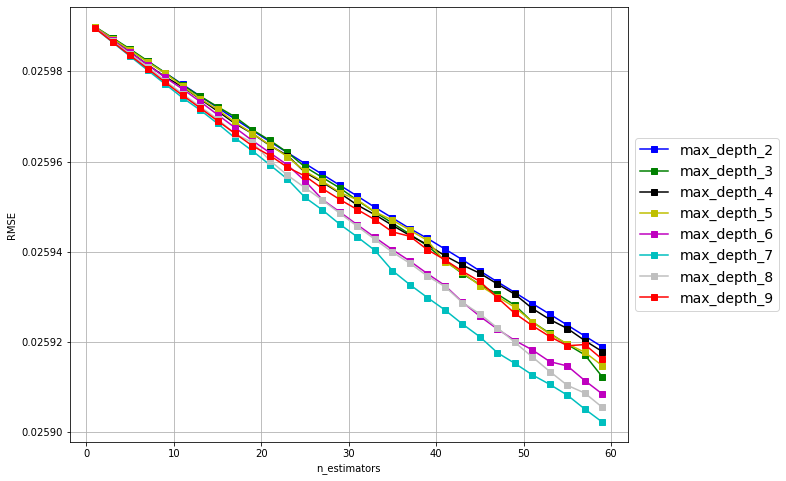

In [100]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
# ax.set_ylim([0, 20])
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [101]:
# Get optimum value for param and param2, using RMSE
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
n_estimators_opt = temp['n_estimators'].values[0]
max_depth_opt = temp['max_depth'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
n_estimators_opt, max_depth_opt

min RMSE = 0.026
optimum params = 


(59, 7)

In [102]:
# Get optimum value for param and param2, using MAPE
temp = error_rate[error_rate['mape'] == error_rate['mape'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape'].min())
print("optimum params = ")
temp['n_estimators'].values[0], temp['max_depth'].values[0]

min MAPE = 2.032%
optimum params = 


(59, 7)

## Tuning learning_rate(default=0.1) and min_child_weight(default=1)

In [103]:
param_label = 'learning_rate'
param_list = [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3]

param2_label = 'min_child_weight'
param2_list = range(5, 21, 1)

error_rate = defaultdict(list)

tic = time.time()
for param in tqdm_notebook(param_list):
    for param2 in param2_list:
        rmse_mean, mape_mean, mae_mean, _ = get_error_metrics(train_val,
                                                              train_size,
                                                              N_opt,
                                                              H,
                                                              seed=model_seed,
                                                              n_estimators=n_estimators_opt,
                                                              max_depth=max_depth_opt,
                                                              learning_rate=param,
                                                              min_child_weight=param2,
                                                              subsample=subsample,
                                                              colsample_bytree=colsample_bytree,
                                                              colsample_bylevel=colsample_bylevel,
                                                              gamma=gamma)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse_mean)
        error_rate['mape'].append(mape_mean)
        error_rate['mae'].append(mae_mean)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = {0:.2f}".format((toc-tic)/60.0))

error_rate   

<ipython-input-103-b0bb9d29de5f>:10: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/8 [00:00<?, ?it/s]

Minutes taken = 157.37


,learning_rate,min_child_weight,rmse,mape,mae
0,0.0001,5,0.025985,2.039715,0.022794
1,0.0001,6,0.025986,2.039838,0.022796
2,0.0001,7,0.025985,2.039713,0.022794
3,0.0001,8,0.025984,2.039699,0.022794
4,0.0001,9,0.025983,2.039662,0.022794
...,...,...,...,...,...
123,0.3000,16,0.025057,1.917565,0.021415
124,0.3000,17,0.024915,1.917347,0.021406
125,0.3000,18,0.024952,1.905401,0.021279
126,0.3000,19,0.023985,1.832420,0.020449


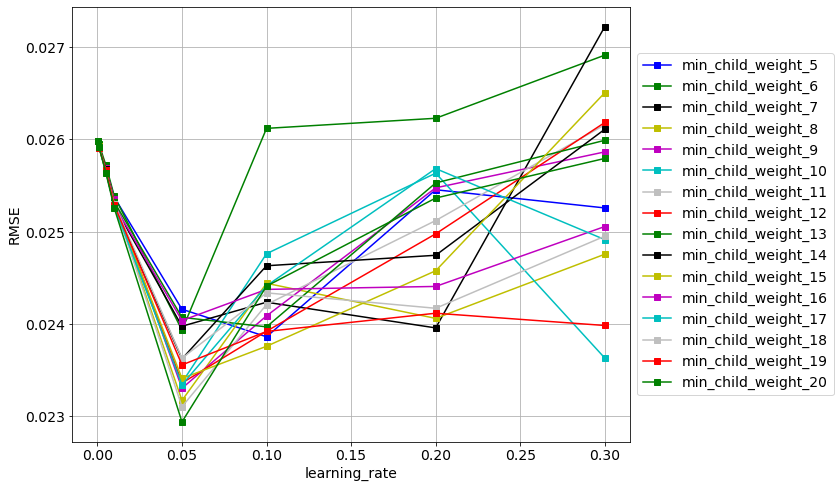

In [104]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
# ax.set_ylim([0, 4])
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [105]:
# Get optimum value for param and param2, using RMSE
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
learning_rate_opt = temp['learning_rate'].values[0]
min_child_weight_opt = temp['min_child_weight'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
learning_rate_opt, min_child_weight_opt

min RMSE = 0.023
optimum params = 


(0.05, 20)

In [106]:
# Get optimum value for param and param2, using MAPE
temp = error_rate[error_rate['mape'] == error_rate['mape'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape'].min())
print("optimum params = ")
temp['learning_rate'].values[0], temp['min_child_weight'].values[0]

min MAPE = 1.766%
optimum params = 


(0.05, 20)

## Tuning XGBoost - subsample(default=1) and gamma(default=0)

In [107]:
param_label = 'subsample'
param_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

param2_label = 'gamma'
param2_list = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

error_rate = defaultdict(list)

tic = time.time()
for param in tqdm_notebook(param_list):
    for param2 in param2_list:
        rmse_mean, mape_mean, mae_mean, _ = get_error_metrics(train_val,
                                                              train_size,
                                                              N_opt,
                                                              H,
                                                              seed=model_seed,
                                                              n_estimators=n_estimators_opt,
                                                              max_depth=max_depth_opt,
                                                              learning_rate=learning_rate_opt,
                                                              min_child_weight=min_child_weight_opt,
                                                              subsample=param,
                                                              colsample_bytree=colsample_bytree,
                                                              colsample_bylevel=colsample_bylevel,
                                                              gamma=param2)

        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse_mean)
        error_rate['mape'].append(mape_mean)
        error_rate['mae'].append(mae_mean)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = {0:.2f}".format((toc-tic)/60.0))

error_rate   

<ipython-input-107-5d97d9276614>:10: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/10 [00:00<?, ?it/s]

Minutes taken = 104.60


,subsample,gamma,rmse,mape,mae
0,0.1,0.0,0.023484,1.808397,0.020231
1,0.1,0.1,0.023480,1.811133,0.020255
2,0.1,0.2,0.023520,1.815664,0.020305
3,0.1,0.3,0.023497,1.812790,0.020276
4,0.1,0.4,0.023467,1.809643,0.020236
...,...,...,...,...,...
105,1.0,0.6,0.022935,1.761627,0.019695
106,1.0,0.7,0.023203,1.782101,0.019935
107,1.0,0.8,0.023303,1.789119,0.020007
108,1.0,0.9,0.023279,1.787960,0.019992


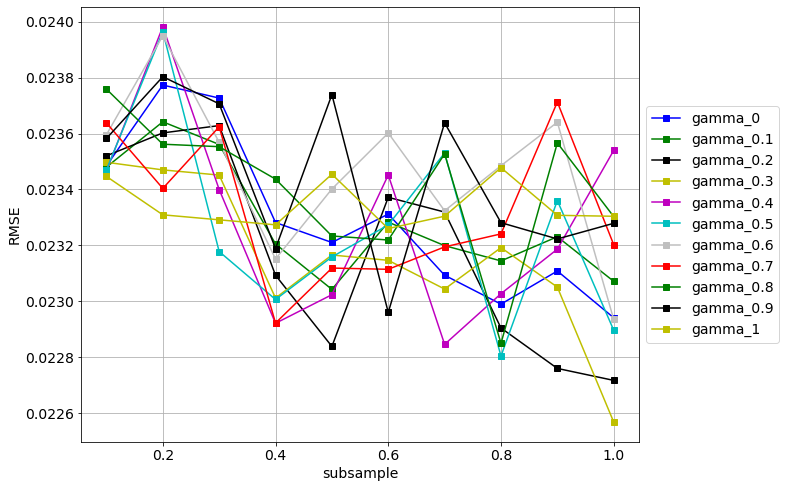

In [108]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [109]:
# Get optimum value for param and param2, using RMSE
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
subsample_opt = temp['subsample'].values[0]
gamma_opt = temp['gamma'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
subsample_opt, gamma_opt

min RMSE = 0.023
optimum params = 


(1.0, 0.3)

In [110]:
# Get optimum value for param and param2, using MAPE
temp = error_rate[error_rate['mape'] == error_rate['mape'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape'].min())
print("optimum params = ")
temp['subsample'].values[0], temp['gamma'].values[0]

min MAPE = 1.734%
optimum params = 


(1.0, 0.3)

## Tuning colsample_bytree(default=1) and colsample_bylevel(default=1)

In [111]:
param_label = 'colsample_bytree'
param_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

param2_label = 'colsample_bylevel'
param2_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

error_rate = defaultdict(list)

tic = time.time()
for param in tqdm_notebook(param_list):    
    for param2 in param2_list:
        rmse_mean, mape_mean, mae_mean, _ = get_error_metrics(train_val,
                                                              train_size,
                                                              N_opt,
                                                              H,
                                                              seed=model_seed,
                                                              n_estimators=n_estimators_opt,
                                                              max_depth=max_depth_opt,
                                                              learning_rate=learning_rate_opt,
                                                              min_child_weight=min_child_weight_opt,
                                                              subsample=subsample_opt,
                                                              colsample_bytree=param,
                                                              colsample_bylevel=param2,
                                                              gamma=gamma_opt)

    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse_mean)
        error_rate['mape'].append(mape_mean)
        error_rate['mae'].append(mae_mean)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = {0:.2f}".format((toc-tic)/60.0))

error_rate   

<ipython-input-111-ce7109c75a87>:10: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/6 [00:00<?, ?it/s]

Minutes taken = 47.93


,colsample_bytree,colsample_bylevel,rmse,mape,mae
0,0.5,0.5,0.023212,1.784044,0.019949
1,0.5,0.6,0.023165,1.783195,0.019947
2,0.5,0.7,0.023470,1.808995,0.020219
3,0.5,0.8,0.023001,1.767676,0.019774
4,0.5,0.9,0.023389,1.800848,0.020140
5,0.5,1.0,0.022857,1.758361,0.019674
6,0.6,0.5,0.022694,1.747989,0.019557
7,0.6,0.6,0.023487,1.811591,0.020266
8,0.6,0.7,0.023203,1.780886,0.019926
9,0.6,0.8,0.023263,1.791137,0.020040


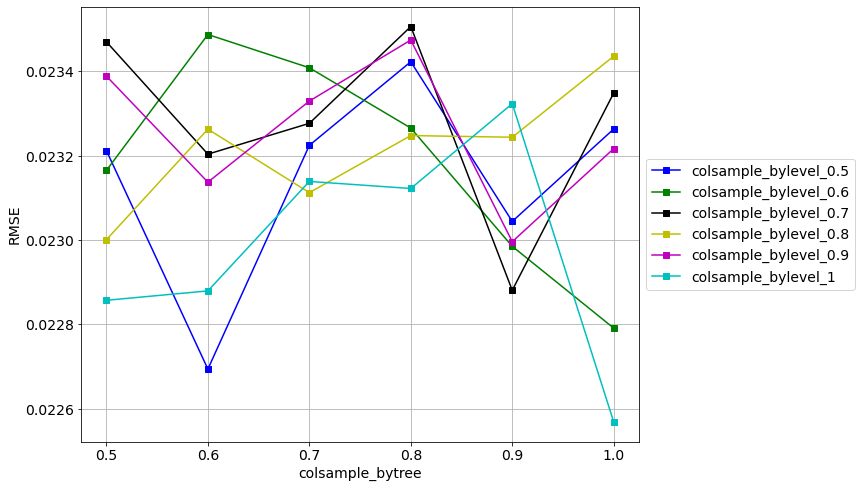

In [112]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [113]:
# Get optimum value for param and param2, using RMSE
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
colsample_bytree_opt = temp['colsample_bytree'].values[0]
colsample_bylevel_opt = temp['colsample_bylevel'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
colsample_bytree_opt, colsample_bylevel_opt

min RMSE = 0.023
optimum params = 


(1.0, 1.0)

In [114]:
# Get optimum value for param and param2, using MAPE
temp = error_rate[error_rate['mape'] == error_rate['mape'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape'].min())
print("optimum params = ")
temp['colsample_bytree'].values[0], temp['colsample_bylevel'].values[0]

min MAPE = 1.734%
optimum params = 


(1.0, 1.0)

## Final model

In [115]:
# Get error metrics on validation set after hyperparameter tuning
rmse_aft_tuning, mape_aft_tuning, mae_aft_tuning, preds_dict = \
                                                      get_error_metrics(train_val,
                                                                        train_size,
                                                                        N_opt,
                                                                        H,
                                                                        seed=model_seed,
                                                                        n_estimators=n_estimators_opt,
                                                                        max_depth=max_depth_opt,
                                                                        learning_rate=learning_rate_opt,
                                                                        min_child_weight=min_child_weight_opt,
                                                                        subsample=subsample_opt,
                                                                        colsample_bytree=colsample_bytree_opt,
                                                                        colsample_bylevel=colsample_bylevel_opt,
                                                                        gamma=gamma_opt)
print("RMSE = %0.3f" % rmse_aft_tuning)
print("MAPE = %0.3f%%" % mape_aft_tuning)
print("MAE = %0.3f" % mae_aft_tuning)

RMSE = 0.023
MAPE = 1.734%
MAE = 0.019


In [135]:
# Plot validation predictions
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=train['date'], 
                         y=train['adj_close'],
                         mode='lines',
                         name='train',
                         line=dict(color='blue')))
fig.add_trace(go.Scatter(x=val['date'], 
                         y=val['adj_close'],
                         mode='lines',
                         name='validation',
                         line=dict(color='orange')))
fig.add_trace(go.Scatter(x=test['date'], 
                         y=test['adj_close'],
                         mode='lines',
                         name='actual',
                         line=dict(color='green')))

# Plot the predictions
n = 0
for key in preds_dict:
    fig.add_trace(go.Scatter(x=train_val[key:key+H]['date'], 
                             y=preds_dict[key],
                             mode='lines',
                             name='predictions',
                             line=dict(color=colors[n%len(colors)])))
    n = n + 1

fig.update_layout(yaxis=dict(title='USD'),
                  xaxis=dict(title='date'))
fig.update_xaxes(range=['2017-10-16', '2018-11-12'])
fig.update_yaxes(range=[127, 157])
py.show(fig, filename='ForexPricePrediction_v6d_xgboost_val_aft_tune')

In [117]:
# Do prediction on test set
test_rmse_aft_tuning, test_mape_aft_tuning, test_mae_aft_tuning, est, feature_importances, features = \
                                            get_error_metrics_one_pred(df[pred_day-train_val_size:pred_day+H],
                                                                       train_size+val_size,
                                                                       N_opt,
                                                                       H,
                                                                       seed=model_seed,
                                                                       n_estimators=n_estimators_opt,
                                                                       max_depth=max_depth_opt,
                                                                       learning_rate=learning_rate_opt,
                                                                       min_child_weight=min_child_weight_opt,
                                                                       subsample=subsample_opt,
                                                                       colsample_bytree=colsample_bytree_opt,
                                                                       colsample_bylevel=colsample_bylevel_opt,
                                                                       gamma=gamma_opt)


print("RMSE = %0.3f" % test_rmse_aft_tuning)
print("MAPE = %0.3f%%" % test_mape_aft_tuning)
print("MAE = %0.3f" % test_mae_aft_tuning)

RMSE = 0.013
MAPE = 0.876%
MAE = 0.010


In [118]:
# Plot test predictions
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=train['date'], 
                         y=train['adj_close'],
                         mode='lines',
                         name='train',
                         line=dict(color='blue')))
fig.add_trace(go.Scatter(x=val['date'], 
                         y=val['adj_close'],
                         mode='lines',
                         name='validation',
                         line=dict(color='orange')))
fig.add_trace(go.Scatter(x=test['date'], 
                         y=test['adj_close'],
                         mode='lines',
                         name='actua',
                         line=dict(color='green')))
fig.add_trace(go.Scatter(x=test[:H]['date'], 
                         y=est,
                         mode='lines',
                         name='predictions',
                         line=dict(color='red')))
fig.update_layout(yaxis=dict(title='USD'),
                  xaxis=dict(title='date'))

In [119]:
# View a list of the features and their importance scores
imp = list(zip(features, feature_importances))
imp.sort(key=lambda tup: tup[1], reverse=False) 
imp

[('is_month_end', 0.0),
 ('is_month_start', 0.0),
 ('is_quarter_end', 0.0),
 ('is_quarter_start', 0.0),
 ('is_year_end', 0.0),
 ('month', 0.012201048),
 ('week', 0.016782166),
 ('adj_close_scaled_lag_6', 0.016905358),
 ('dayofyear', 0.017355788),
 ('adj_close_scaled_lag_4', 0.017398365),
 ('adj_close_scaled_lag_18', 0.017487332),
 ('adj_close_scaled_lag_5', 0.017840037),
 ('adj_close_scaled_lag_15', 0.017941086),
 ('adj_close_scaled_lag_11', 0.017988365),
 ('adj_close_scaled_lag_14', 0.018377108),
 ('year', 0.018625183),
 ('adj_close_scaled_lag_3', 0.019209998),
 ('adj_close_scaled_lag_9', 0.019365823),
 ('adj_close_scaled_lag_7', 0.019921781),
 ('dayofweek', 0.019931387),
 ('adj_close_scaled_lag_10', 0.020013368),
 ('adj_close_scaled_lag_12', 0.020152718),
 ('adj_close_scaled_lag_17', 0.02024174),
 ('day', 0.020398194),
 ('adj_close_scaled_lag_13', 0.02148904),
 ('adj_close_scaled_lag_8', 0.02167615),
 ('adj_close_scaled_lag_16', 0.02213039),
 ('adj_close_scaled_lag_2', 0.024670757),


In [120]:
# Plot the importance scores as a bar chart
fig = go.Figure(go.Bar(
            x=[item[1] for item in imp[-10:]],
            y=[item[0] for item in imp[-10:]],
            orientation='h'))
py.show(fig, filename='ForexPricePrediction_v6d_xgboost_imp_scores')

## Tuned params

In [121]:
# Tuned params and before and after error metrics
d = {'param': ['n_estimators', 'max_depth', 'learning_rate', 'min_child_weight', 'subsample', 'colsample_bytree', 'colsample_bylevel', 'gamma', 'val_rmse', 'val_mape', 'val_mae'],
     'before_tuning': [n_estimators, max_depth, learning_rate, min_child_weight, subsample, colsample_bytree, colsample_bylevel, gamma, rmse_bef_tuning, mape_bef_tuning, mae_bef_tuning],
     'after_tuning': [n_estimators_opt, max_depth_opt, learning_rate_opt, min_child_weight_opt, subsample_opt, colsample_bytree_opt, colsample_bylevel_opt, gamma_opt, rmse_aft_tuning, mape_aft_tuning, mae_aft_tuning]}
tuned_params = pd.DataFrame(d)
tuned_params = tuned_params.round(3)
tuned_params

,param,before_tuning,after_tuning
0,n_estimators,100.000,59.000
1,max_depth,4.000,7.000
2,learning_rate,0.001,0.050
3,min_child_weight,1.000,20.000
4,subsample,1.000,1.000
5,colsample_bytree,1.000,1.000
6,colsample_bylevel,1.000,1.000
7,gamma,0.000,0.300
8,val_rmse,0.026,0.023
9,val_mape,2.028,1.734


In [122]:
# Put tuned_params into pickle
# outfile = open(filename,'wb')
pickle.dump(tuned_params, open("C:/Users/Mister KwameNtow/Documents/GitHub/project/v6d_tuned_params_" + df.iloc[pred_day]['date'].strftime("%Y-%m-%d") + ".pickle", "wb"))

In [123]:
pickle.load(open("C:/Users/Mister KwameNtow/Documents/GitHub/project/v6d_tuned_params_" + df.iloc[pred_day]['date'].strftime("%Y-%m-%d") + ".pickle", "rb"))

,param,before_tuning,after_tuning
0,n_estimators,100.000,59.000
1,max_depth,4.000,7.000
2,learning_rate,0.001,0.050
3,min_child_weight,1.000,20.000
4,subsample,1.000,1.000
5,colsample_bytree,1.000,1.000
6,colsample_bylevel,1.000,1.000
7,gamma,0.000,0.300
8,val_rmse,0.026,0.023
9,val_mape,2.028,1.734


In [124]:
toc1 = time.time()
print("Total minutes taken = {0:.2f}".format((toc1-tic1)/60.0))

Total minutes taken = 543.25


# Findings

In [125]:
print("Predicting on day %d, date %s, with forecast horizon H = %d" % (pred_day, df.iloc[pred_day]['date'].strftime("%Y-%m-%d"), H))

Predicting on day 2600, date 2017-08-11, with forecast horizon H = 30


In [126]:
rmse_bef_tuning, rmse_aft_tuning

(0.025864115661535476, 0.022568441526398284)

In [127]:
test_rmse_bef_tuning, test_rmse_aft_tuning

(0.011350072995358151, 0.012574412599890802)

In [128]:
# Put results into pickle
pickle.dump(rmse_bef_tuning, open("C:/Users/Mister KwameNtow/Documents/GitHub/project/v6d_val_rmse_bef_tuning_" + df.iloc[pred_day]['date'].strftime("%Y-%m-%d") + ".pickle", "wb"))
pickle.dump(rmse_aft_tuning, open("C:/Users/Mister KwameNtow/Documents/GitHub/project/v6d_val_rmse_aft_tuning_" + df.iloc[pred_day]['date'].strftime("%Y-%m-%d") + ".pickle", "wb"))
pickle.dump(test_rmse_bef_tuning, open("C:/Users/Mister KwameNtow/Documents/GitHub/project/v6d_test_rmse_bef_tuning_" + df.iloc[pred_day]['date'].strftime("%Y-%m-%d") + ".pickle", "wb"))
pickle.dump(test_mape_bef_tuning, open("C:/Users/Mister KwameNtow/Documents/GitHub/project/v6d_test_mape_bef_tuning_" + df.iloc[pred_day]['date'].strftime("%Y-%m-%d") + ".pickle", "wb"))
pickle.dump(test_mae_bef_tuning, open("C:/Users/Mister KwameNtow/Documents/GitHub/project/v6d_test_mae_bef_tuning_" + df.iloc[pred_day]['date'].strftime("%Y-%m-%d") + ".pickle", "wb"))
pickle.dump(test_rmse_aft_tuning, open("C:/Users/Mister KwameNtow/Documents/GitHub/project/v6d_test_rmse_aft_tuning_" + df.iloc[pred_day]['date'].strftime("%Y-%m-%d") + ".pickle", "wb"))
pickle.dump(test_mape_aft_tuning, open("C:/Users/Mister KwameNtow/Documents/GitHub/project/v6d_test_mape_aft_tuning_" + df.iloc[pred_day]['date'].strftime("%Y-%m-%d") + ".pickle", "wb"))
pickle.dump(test_mae_aft_tuning, open("C:/Users/Mister KwameNtow/Documents/GitHub/project/v6d_test_mae_aft_tuning_" + df.iloc[pred_day]['date'].strftime("%Y-%m-%d") + ".pickle", "wb"))
pickle.dump(est, open("C:/Users/Mister KwameNtow/Documents/GitHub/project/v6d_test_est_aft_tuning_" + df.iloc[pred_day]['date'].strftime("%Y-%m-%d") + ".pickle", "wb"))

In [129]:
# Consolidate results
# H = 21                         # Forecast horizon, in days. Note there are about 252 trading days in a year
# train_size = 252*3             # Use 3 years of data as train set. Note there are about 252 trading days in a year
# val_size = 252                 # Use 1 year of data as validation set
# N = 10                          # for feature at day t, we use lags from t-1, t-2, ..., t-N as features
results = defaultdict(list)
ests = {} # the predictions
date_list = ['2015-04-24',
            #  '2015-04-25',
            #  '2015-04-30',
            #  '2015-05-03',
            #  '2015-05-07',
            #  '2015-05-12',
            #  '2015-05-24',
            #  '2015-05-27',
            #  '2015-06-03',
            #  '2015-06-05',
            #  '2015-06-12',
            '2017-03-24'
            ]
for date in date_list:
    results['date'].append(date)
    results['val_rmse_bef_tuning'].append(pickle.load(open( "C:/Users/Mister KwameNtow/Documents/GitHub/project/v6d_val_rmse_bef_tuning_" + date + ".pickle", "rb")))
    results['val_rmse_aft_tuning'].append(pickle.load(open( "C:/Users/Mister KwameNtow/Documents/GitHub/project/v6d_val_rmse_aft_tuning_" + date + ".pickle", "rb")))
    results['test_rmse_bef_tuning'].append(pickle.load(open( "C:/Users/Mister KwameNtow/Documents/GitHub/project/v6d_test_rmse_bef_tuning_" + date + ".pickle", "rb")))
    results['test_rmse_aft_tuning'].append(pickle.load(open( "C:/Users/Mister KwameNtow/Documents/GitHub/project/v6d_test_rmse_aft_tuning_" + date + ".pickle", "rb")))
    results['test_mape_bef_tuning'].append(pickle.load(open( "C:/Users/Mister KwameNtow/Documents/GitHub/project/v6d_test_mape_bef_tuning_" + date + ".pickle", "rb")))
    results['test_mape_aft_tuning'].append(pickle.load(open( "C:/Users/Mister KwameNtow/Documents/GitHub/project/v6d_test_mape_aft_tuning_" + date + ".pickle", "rb")))
    results['test_mae_bef_tuning'].append(pickle.load(open( "C:/Users/Mister KwameNtow/Documents/GitHub/project/v6d_test_mae_bef_tuning_" + date + ".pickle", "rb")))
    results['test_mae_aft_tuning'].append(pickle.load(open( "C:/Users/Mister KwameNtow/Documents/GitHub/project/v6d_test_mae_aft_tuning_" + date + ".pickle", "rb")))
    ests[date] = pickle.load(open( "C:/Users/Mister KwameNtow/Documents/GitHub/project/v6d_test_est_aft_tuning_" + date + ".pickle", "rb"))
    
results = pd.DataFrame(results)
results

,date,val_rmse_bef_tuning,val_rmse_aft_tuning,test_rmse_bef_tuning,test_rmse_aft_tuning,test_mape_bef_tuning,test_mape_aft_tuning,test_mae_bef_tuning,test_mae_aft_tuning
0,2015-04-24,0.025399,0.017751,0.037368,0.042027,2.954566,3.450095,0.033095,0.038586
1,2017-03-24,0.025863,0.021711,0.011978,0.011414,1.012522,0.974585,0.010909,0.010490


In [130]:
# Generate a condensed dataframe of the above
results_short = defaultdict(list)
hyperparam_list = ['n_estimators', 
                   'max_depth', 
                   'learning_rate', 
                   'min_child_weight',
#                    'subsample',
#                    'colsample_bytree',
#                    'colsample_bylevel',
#                    'gamma'
                  ]

for date in date_list:
    results_short['date'].append(date)
    results_short['RMSE'].append(pickle.load(open( "C:/Users/Mister KwameNtow/Documents/GitHub/project/v6d_test_rmse_aft_tuning_" + date + ".pickle", "rb")))
    results_short['MAPE(%)'].append(pickle.load(open( "C:/Users/Mister KwameNtow/Documents/GitHub/project/v6d_test_mape_aft_tuning_" + date + ".pickle", "rb")))
    results_short['MAE'].append(pickle.load(open( "C:/Users/Mister KwameNtow/Documents/GitHub/project/v6d_test_mae_aft_tuning_" + date + ".pickle", "rb")))
    
    tuned_params = pickle.load(open("C:/Users/Mister KwameNtow/Documents/GitHub/project//v6d_tuned_params_" + date + ".pickle", "rb"))
    for hyperparam in hyperparam_list:
        results_short[hyperparam].append(tuned_params[tuned_params['param']==hyperparam]['after_tuning'].values[0])

    
results_short = pd.DataFrame(results_short)
results_short

,date,RMSE,MAPE(%),MAE,n_estimators,max_depth,learning_rate,min_child_weight
0,2015-04-24,0.042027,3.450095,0.038586,59.0,3.0,0.20,11.0
1,2017-03-24,0.011414,0.974585,0.010490,59.0,6.0,0.05,19.0


In [131]:
results.mean()

val_rmse_bef_tuning     0.025631
val_rmse_aft_tuning     0.019731
test_rmse_bef_tuning    0.024673
test_rmse_aft_tuning    0.026720
test_mape_bef_tuning    1.983544
test_mape_aft_tuning    2.212340
test_mae_bef_tuning     0.022002
test_mae_aft_tuning     0.024538
dtype: float64

In [132]:
# Plot all predictions
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=df['date'], 
                         y=df['adj_close'],
                         mode='lines',
                         name='adj_close',
                         line=dict(color='blue')))

# Plot the predictions
n = 0
for key in ests:
    i = df[df['date']==key].index[0]
    fig.add_trace(go.Scatter(x=df[i:i+H]['date'], 
                             y=ests[key],
                             mode='lines',
                             name='predictions',
                             line=dict(color=colors[n%len(colors)])))
    n = n + 1

fig.update_layout(yaxis=dict(title='USD'),
                  xaxis=dict(title='date'))
fig.update_xaxes(range=['2010-01-03', '2011-12-28'])
fig.update_yaxes(range=[110, 150])
py.show(fig, filename='ForexPricePrediction_v6d_xgboost_predictions')

In [133]:
# Plot scatter plot of actual values vs. predictions
fig = go.Figure()

n = 0
for key in ests:
    i = df[df['date']==key].index[0]
    fig.add_trace(go.Scatter(x=df[i:i+H]['adj_close'], 
                             y=ests[key],
                             mode='markers',
                             name='predictions',
                             line=dict(color=colors[n%len(colors)])))
    n = n + 1

fig.add_trace(go.Scatter(x=list(range(110, 155, 1)),
                         y=list(range(110, 155, 1)),
                         mode='lines',
                         name='actual values',
                         line=dict(color='blue')))

fig.update_layout(yaxis=dict(title='forecasts'),
                  xaxis=dict(title='adj_close'))
py.show(fig, filename='ForexPricePrediction_v6d_xgboost_actuals_vs_predictions')

In [134]:
# Compare results with benchmark
all_results = pd.DataFrame({'Method': ['Last value',  'XGBoost w/o date features', 'XGBoost w date features'],
                            'RMSE': [2.53, 2.32, 2.42],
                            'MAPE(%)': [1.69, 1.53, 1.61],
                            'MAE': [2.26, 2.05, 2.15]})
all_results

,Method,RMSE,MAPE(%),MAE
0,Last value,2.53,1.69,2.26
1,XGBoost w/o date features,2.32,1.53,2.05
2,XGBoost w date features,2.42,1.61,2.15
